# Scenario Comparison and Annotation Framework Demo

This notebook demonstrates the comprehensive scenario comparison and annotation framework,
including:
- Side-by-side scenario comparisons
- Automatic insight extraction
- Smart annotation placement
- Natural language generation
- Statistical significance testing

In [1]:
# Standard imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath('../..'))

# Project imports
from ergodic_insurance.src.config_manager import ConfigManager
from ergodic_insurance.src.manufacturer import WidgetManufacturer
from ergodic_insurance.src.simulation import Simulation
from ergodic_insurance.src.scenario_manager import ScenarioManager, ParameterSpec
from ergodic_insurance.src.batch_processor import BatchProcessor

# New comparison framework imports
from ergodic_insurance.src.reporting.scenario_comparator import ScenarioComparator
from ergodic_insurance.src.reporting.insight_extractor import InsightExtractor
from ergodic_insurance.src.visualization.annotations import (
    SmartAnnotationPlacer,
    auto_annotate_peaks_valleys,
    create_leader_line
)

# Set style
from ergodic_insurance.src.visualization.core import set_wsj_style
set_wsj_style()

print("Framework loaded successfully!")

Framework loaded successfully!


## 1. Create Multiple Scenarios for Comparison

In [2]:
# Create scenario manager
scenario_mgr = ScenarioManager()

# Load base configuration
config_mgr = ConfigManager()
base_config = config_mgr.load_profile('default')

# Define parameter specifications for sensitivity analysis
param_specs = [
    ParameterSpec(
        name='insurance.premium_rate',
        base_value=0.015,
        variation_pct=0.3
    ),
    ParameterSpec(
        name='insurance.limit',
        base_value=5000000,
        variation_pct=0.5
    ),
    ParameterSpec(
        name='manufacturer.target_margin',
        base_value=0.08,
        variation_pct=0.25
    )
]

# Create scenarios
scenarios = scenario_mgr.create_sensitivity_analysis(
    base_name='insurance_optimization',
    parameter_specs=param_specs,
    base_config=base_config,
    tags={'demo', 'comparison'}
)

print(f"Created {len(scenarios)} scenarios for comparison:")
for scenario in scenarios:
    print(f"  - {scenario.name}: {scenario.description}")

Created 7 scenarios for comparison:
  - insurance_optimization_baseline: Baseline scenario
  - insurance_optimization_insurance_premium_rate_low: Sensitivity: insurance.premium_rate low
  - insurance_optimization_insurance_premium_rate_high: Sensitivity: insurance.premium_rate high
  - insurance_optimization_insurance_limit_low: Sensitivity: insurance.limit low
  - insurance_optimization_insurance_limit_high: Sensitivity: insurance.limit high
  - insurance_optimization_manufacturer_target_margin_low: Sensitivity: manufacturer.target_margin low
  - insurance_optimization_manufacturer_target_margin_high: Sensitivity: manufacturer.target_margin high


## 2. Run Simulations and Collect Results

In [3]:
# For demo purposes, we'll create synthetic results
# In practice, you would run actual simulations

def create_synthetic_results(scenario_name, param_overrides):
    """Create synthetic results for demonstration."""
    np.random.seed(hash(scenario_name) % 2**32)
    
    # Base metrics
    base_growth = 0.06
    base_ruin = 0.015
    base_assets = 10000000
    
    # Adjust based on parameters
    if 'insurance.premium_rate' in param_overrides:
        premium_effect = (param_overrides['insurance.premium_rate'] - 0.015) * 100
        base_growth -= premium_effect * 0.5
        base_ruin += premium_effect * 0.3
    
    if 'insurance.limit' in param_overrides:
        limit_effect = (param_overrides['insurance.limit'] - 5000000) / 5000000
        base_ruin *= (1 - limit_effect * 0.4)
        base_growth += limit_effect * 0.01
    
    if 'manufacturer.target_margin' in param_overrides:
        margin_effect = (param_overrides['manufacturer.target_margin'] - 0.08) / 0.08
        base_growth += margin_effect * 0.02
        base_assets *= (1 + margin_effect * 0.15)
    
    # Add some randomness
    growth_rate = base_growth + np.random.normal(0, 0.005)
    ruin_prob = max(0, base_ruin + np.random.normal(0, 0.002))
    final_assets = base_assets * (1 + np.random.normal(0, 0.1))
    
    # Create time series for trends
    n_periods = 50
    time_series_growth = np.cumsum(np.random.normal(growth_rate/n_periods, 0.01, n_periods))
    time_series_assets = base_assets * np.exp(time_series_growth)
    
    return {
        'summary_statistics': {
            'mean_growth_rate': growth_rate,
            'ruin_probability': ruin_prob,
            'mean_final_assets': final_assets,
            'var_95': -np.random.uniform(50000, 200000),
            'var_99': -np.random.uniform(100000, 500000),
            'sharpe_ratio': growth_rate / 0.15,
            'max_drawdown': np.random.uniform(0.05, 0.25)
        },
        'time_series': {
            'growth_rate': time_series_growth,
            'assets': time_series_assets
        },
        'config': param_overrides
    }

# Generate results for all scenarios
results = {}
for scenario in scenarios:
    results[scenario.name] = create_synthetic_results(
        scenario.name,
        scenario.parameter_overrides
    )

print(f"Generated results for {len(results)} scenarios")
print("\nSample metrics for baseline:")
baseline_name = 'insurance_optimization_baseline'
if baseline_name in results:
    for metric, value in results[baseline_name]['summary_statistics'].items():
        print(f"  {metric}: {value:.4f}")

Generated results for 7 scenarios

Sample metrics for baseline:
  mean_growth_rate: 0.0608
  ruin_probability: 0.0146
  mean_final_assets: 9411362.3445
  var_95: -118009.3999
  var_99: -469802.3458
  sharpe_ratio: 0.4051
  max_drawdown: 0.2321


## 3. Compare Scenarios Using the Framework

In [4]:
# Initialize comparator
comparator = ScenarioComparator()

# Compare scenarios
comparison = comparator.compare_scenarios(
    results,
    baseline='insurance_optimization_baseline',
    metrics=['mean_growth_rate', 'ruin_probability', 'mean_final_assets', 'sharpe_ratio']
)

print("Comparison Analysis Complete!")
print(f"\nScenarios compared: {', '.join(comparison.scenarios)}")
print(f"\nMetrics analyzed: {', '.join(comparison.metrics.keys())}")

# Show top performers
print("\n=== Top Performers ===")
for metric in ['mean_growth_rate', 'ruin_probability']:
    ascending = 'risk' in metric or 'ruin' in metric
    top = comparison.get_top_performers(metric, n=3, ascending=ascending)
    print(f"\n{metric.replace('_', ' ').title()}:")
    for scenario, value in top:
        print(f"  {scenario}: {value:.4f}")

Comparison Analysis Complete!

Scenarios compared: insurance_optimization_baseline, insurance_optimization_insurance_premium_rate_low, insurance_optimization_insurance_premium_rate_high, insurance_optimization_insurance_limit_low, insurance_optimization_insurance_limit_high, insurance_optimization_manufacturer_target_margin_low, insurance_optimization_manufacturer_target_margin_high

Metrics analyzed: mean_growth_rate, ruin_probability, mean_final_assets, sharpe_ratio

=== Top Performers ===

Mean Growth Rate:
  insurance_optimization_insurance_premium_rate_low: 0.2829
  insurance_optimization_manufacturer_target_margin_high: 0.0670
  insurance_optimization_insurance_limit_high: 0.0653

Ruin Probability:
  insurance_optimization_insurance_premium_rate_low: 0.0000
  insurance_optimization_insurance_limit_high: 0.0102
  insurance_optimization_manufacturer_target_margin_low: 0.0117


## 4. Create Comparison Visualizations

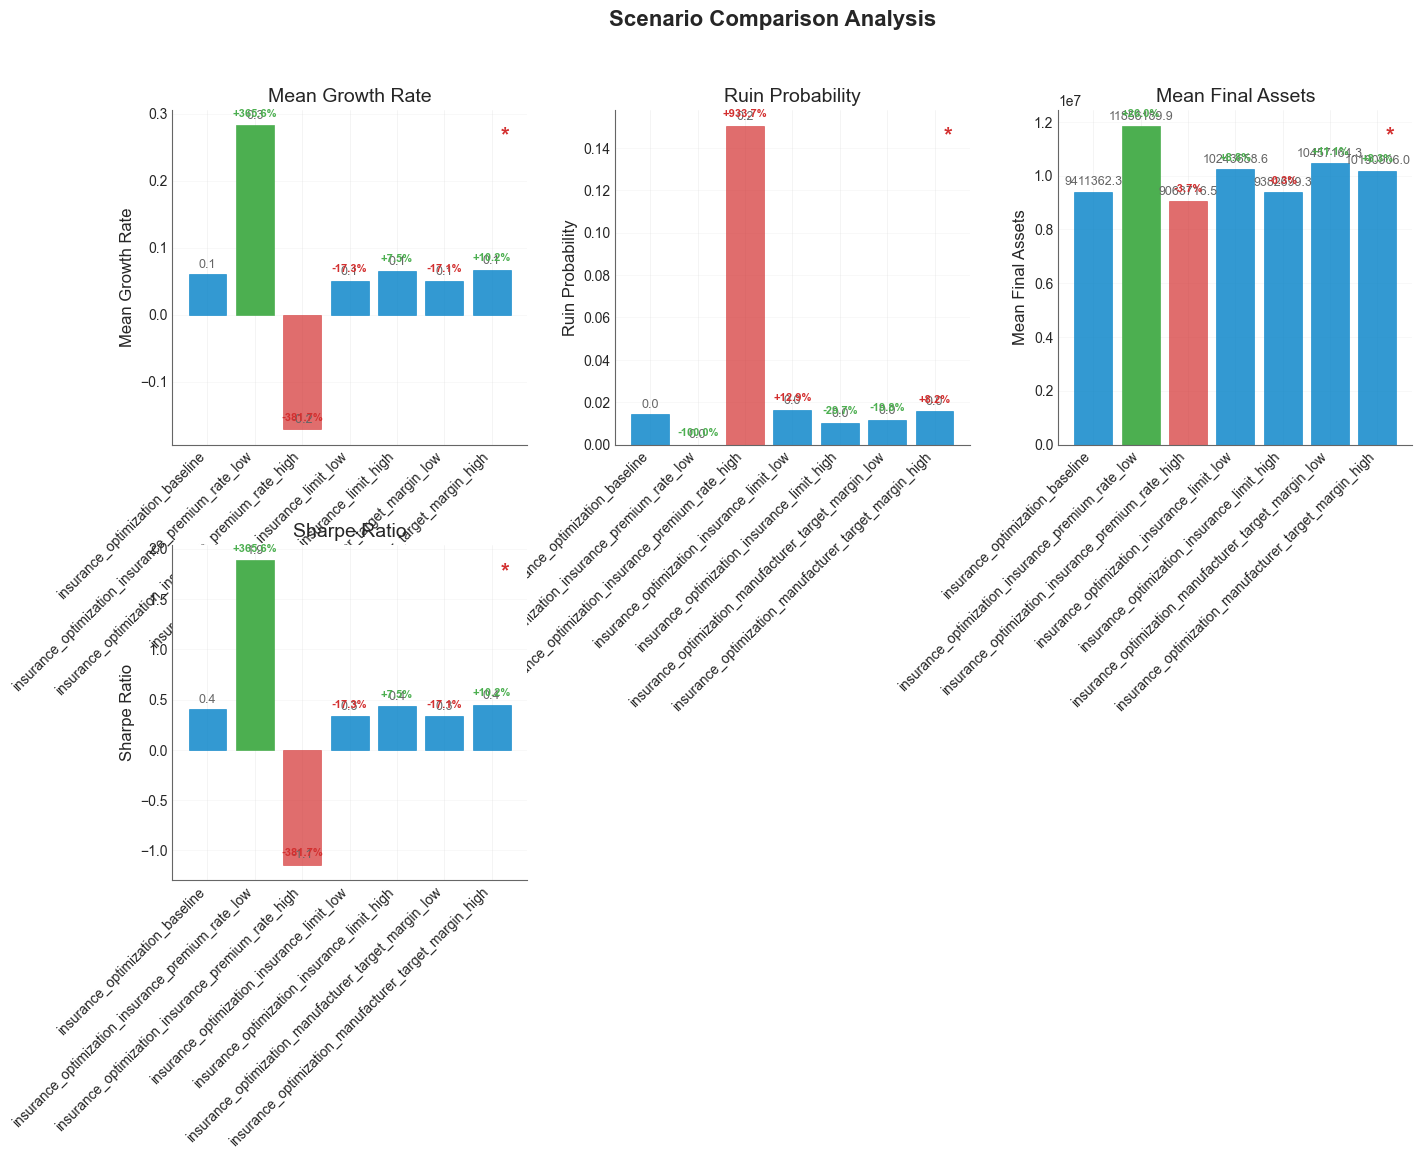

Comparison grid created with difference indicators from baseline


In [5]:
# Create comprehensive comparison grid
fig = comparator.create_comparison_grid(
    metrics=['mean_growth_rate', 'ruin_probability', 'mean_final_assets', 'sharpe_ratio'],
    figsize=(16, 10),
    show_diff=True
)

plt.tight_layout()
plt.show()

print("Comparison grid created with difference indicators from baseline")

## 5. Extract and Display Insights

In [6]:
# Initialize insight extractor
extractor = InsightExtractor()

# Extract insights from comparison
insights = extractor.extract_insights(
    comparison,
    focus_metrics=['mean_growth_rate', 'ruin_probability'],
    threshold_importance=50
)

print(f"Extracted {len(insights)} insights:\n")

# Display top insights
for i, insight in enumerate(insights[:5], 1):
    print(f"{i}. [{insight.category.upper()}] {insight.title}")
    print(f"   {insight.description}")
    print(f"   Importance: {insight.importance:.0f}/100 | Confidence: {insight.confidence:.1%}")
    print()

Extracted 5 insights:

1. [THRESHOLD] Critical Threshold Exceeded for Ruin Probability
   ruin probability exceeded the critical threshold of 1.00% in 6 scenarios
   Importance: 100/100 | Confidence: 95.0%

2. [THRESHOLD] Critical Threshold Exceeded for Mean Growth Rate
   mean growth rate exceeded the critical threshold of 0.00% in 1 scenarios
   Importance: 75/100 | Confidence: 95.0%

3. [CORRELATION] Strong Correlation Between Metrics
   Strong negative correlation (-0.83) detected between mean growth rate and ruin probability
   Importance: 75/100 | Confidence: 97.8%

4. [OUTLIER] Outlier Detected in Ruin Probability
   insurance_optimization_insurance_premium_rate_high exhibits exceptionally high ruin probability (15.04%), 2.4 standard deviations above mean
   Importance: 74/100 | Confidence: 85.0%

5. [PERFORMANCE] Underperformance in Ruin Probability
   The insurance_optimization_insurance_premium_rate_high scenario showed the weakest ruin probability at 15.04%, underperforming 

## 6. Generate Executive Summary

In [7]:
# Generate executive summary
executive_summary = extractor.generate_executive_summary(
    max_points=5,
    focus_positive=True
)

print(executive_summary)

# Generate technical notes
print("\n## Technical Notes\n")
technical_notes = extractor.generate_technical_notes()
for note in technical_notes:
    print(f"• {note}")

## Executive Summary

### Key Findings:

- average return exceeded the critical threshold of 0.00% in 1 scenarios

## Technical Notes

• Outlier Detection: 1 anomalous scenarios detected
• Risk Assessment: 2 metrics exceeded critical thresholds
• Correlation Analysis: 1 significant relationships identified
• High Confidence: 3 insights with >90% statistical confidence


## 7. Demonstrate Smart Annotation Placement

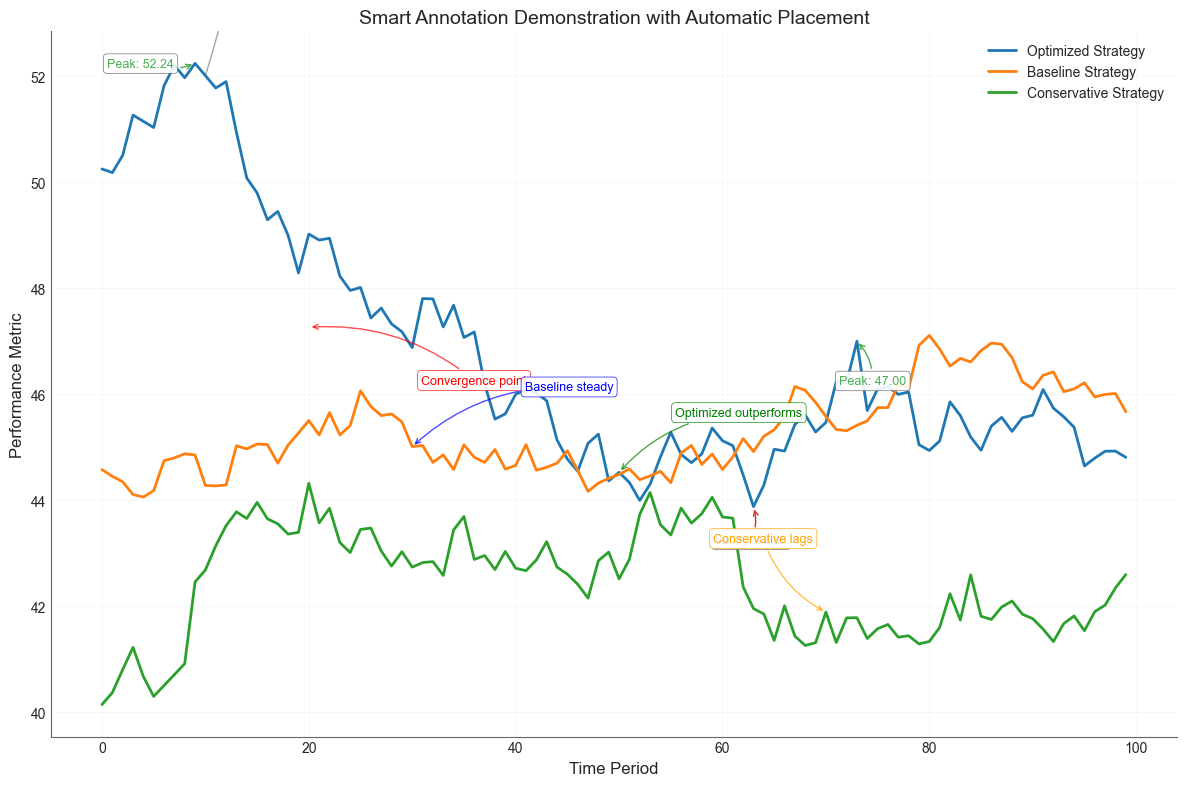

Smart annotations placed without overlaps!


In [8]:
# Create a sample plot with smart annotations
fig, ax = plt.subplots(figsize=(12, 8))

# Generate sample time series data
np.random.seed(42)
x = np.arange(0, 100)
y1 = np.cumsum(np.random.randn(100) * 0.5) + 50
y2 = np.cumsum(np.random.randn(100) * 0.3) + 45
y3 = np.cumsum(np.random.randn(100) * 0.4) + 40

# Plot lines
ax.plot(x, y1, label='Optimized Strategy', linewidth=2)
ax.plot(x, y2, label='Baseline Strategy', linewidth=2)
ax.plot(x, y3, label='Conservative Strategy', linewidth=2)

# Initialize smart annotation placer
placer = SmartAnnotationPlacer(ax)

# Find key points to annotate
annotations = [
    {
        'text': 'Optimized outperforms',
        'point': (50, y1[50]),
        'priority': 90,
        'color': 'green'
    },
    {
        'text': 'Baseline steady',
        'point': (30, y2[30]),
        'priority': 70,
        'color': 'blue'
    },
    {
        'text': 'Conservative lags',
        'point': (70, y3[70]),
        'priority': 60,
        'color': 'orange'
    },
    {
        'text': 'Convergence point',
        'point': (20, (y1[20] + y2[20])/2),
        'priority': 80,
        'color': 'red'
    }
]

# Add annotations with smart placement
placer.add_smart_annotations(annotations)

# Automatically annotate peaks and valleys
auto_annotate_peaks_valleys(ax, x, y1, n_peaks=2, n_valleys=1)

# Add leader lines for emphasis
create_leader_line(ax, (10, y1[10]), (15, y1[10]+5), style='curved', color='gray')

# Format plot
ax.set_xlabel('Time Period')
ax.set_ylabel('Performance Metric')
ax.set_title('Smart Annotation Demonstration with Automatic Placement')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Smart annotations placed without overlaps!")

## 8. Create Parameter Difference Table

In [9]:
# Create parameter difference tables for key scenarios
for scenario_name in comparison.scenarios[1:3]:  # Show first 2 non-baseline scenarios
    print(f"\n=== Parameter Differences: {scenario_name} ===")
    
    diff_table = comparator.create_parameter_diff_table(
        scenario_name,
        threshold=5.0  # Show changes > 5%
    )
    
    if not diff_table.empty:
        print(diff_table.to_string(index=False))
    else:
        print("No significant parameter differences found.")


=== Parameter Differences: insurance_optimization_insurance_premium_rate_low ===
No significant parameter differences found.

=== Parameter Differences: insurance_optimization_insurance_premium_rate_high ===
No significant parameter differences found.


## 9. A/B Testing Visualization

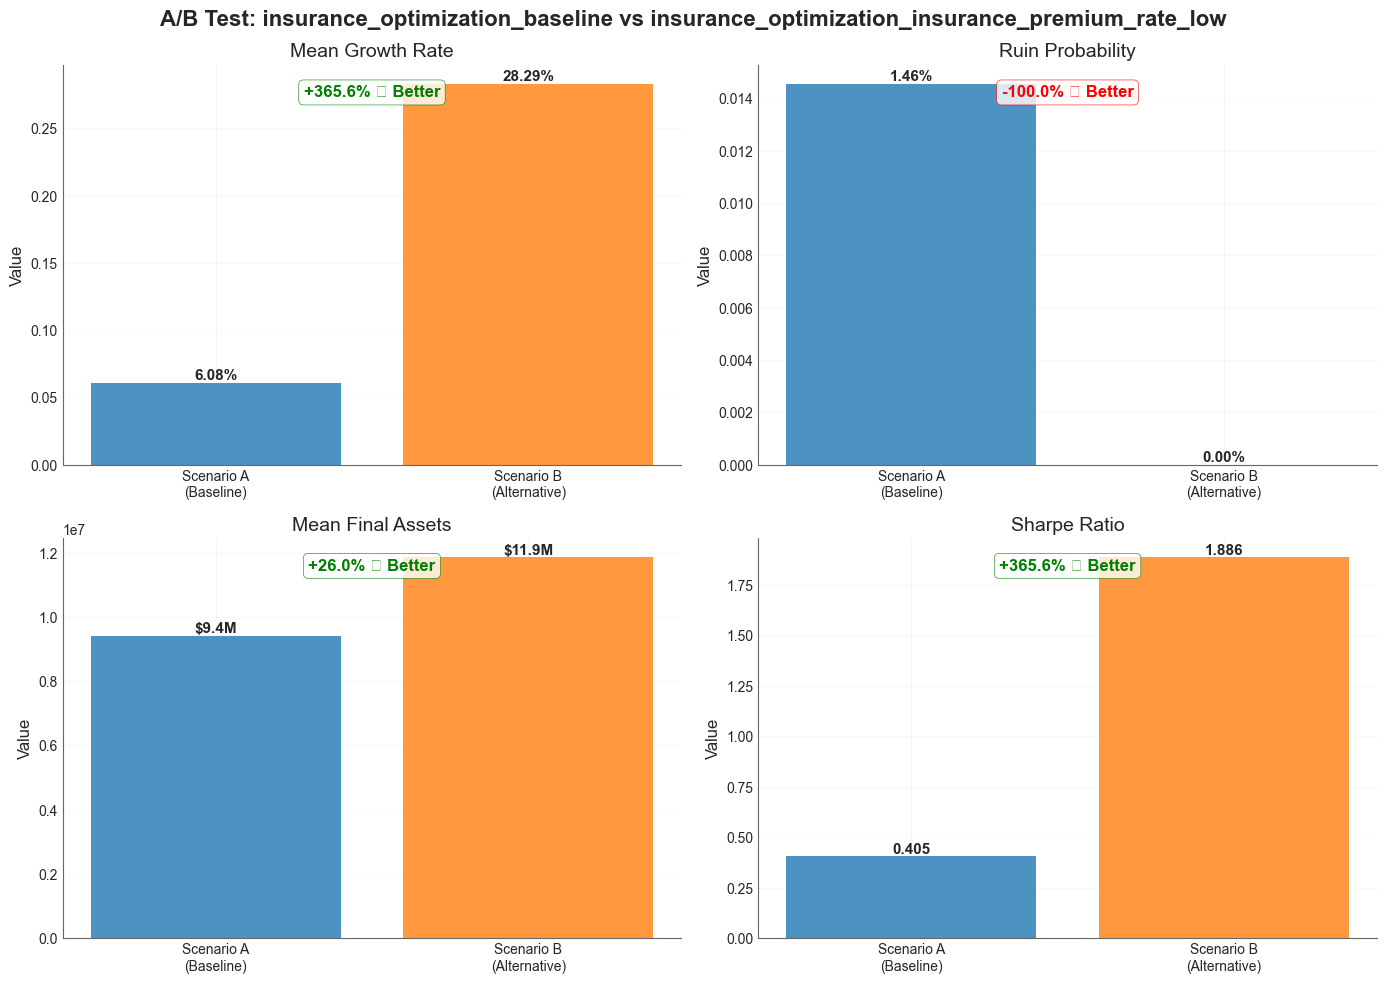

A/B testing visualization complete!


In [10]:
# Create A/B testing visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Select two scenarios for A/B comparison
scenario_a = 'insurance_optimization_baseline'
scenario_b = list(comparison.scenarios)[1] if len(comparison.scenarios) > 1 else scenario_a

metrics_to_compare = ['mean_growth_rate', 'ruin_probability', 'mean_final_assets', 'sharpe_ratio']

for idx, metric in enumerate(metrics_to_compare):
    ax = axes[idx]
    
    # Get values
    val_a = comparison.metrics[metric].get(scenario_a, 0)
    val_b = comparison.metrics[metric].get(scenario_b, 0)
    
    # Create bar plot
    bars = ax.bar(['Scenario A\n(Baseline)', 'Scenario B\n(Alternative)'], 
                   [val_a, val_b],
                   color=['#1f77b4', '#ff7f0e'],
                   alpha=0.8)
    
    # Add value labels
    for bar, val in zip(bars, [val_a, val_b]):
        height = bar.get_height()
        if 'probability' in metric or 'rate' in metric:
            label = f'{val:.2%}'
        elif 'assets' in metric:
            label = f'${val/1e6:.1f}M'
        else:
            label = f'{val:.3f}'
        
        ax.text(bar.get_x() + bar.get_width()/2, height,
               label, ha='center', va='bottom', fontweight='bold')
    
    # Calculate and show difference
    diff = ((val_b - val_a) / val_a * 100) if val_a != 0 else 0
    color = 'green' if diff > 0 else 'red'
    
    # Determine if improvement based on metric type
    if 'risk' in metric or 'ruin' in metric or 'drawdown' in metric:
        improvement = diff < 0
    else:
        improvement = diff > 0
    
    status = '✓ Better' if improvement else '✗ Worse'
    
    ax.text(0.5, 0.95, f'{diff:+.1f}% {status}',
           transform=ax.transAxes,
           ha='center', va='top',
           fontsize=12, fontweight='bold',
           color=color,
           bbox=dict(boxstyle='round', facecolor='white', edgecolor=color, alpha=0.8))
    
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle(f'A/B Test: {scenario_a} vs {scenario_b}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("A/B testing visualization complete!")

## 10. Export Comparison Report

In [11]:
# Export comprehensive comparison report
import os
output_dir = 'comparison_reports'
os.makedirs(output_dir, exist_ok=True)

output_base = os.path.join(output_dir, 'scenario_comparison')

# Export comparison data
output_files = comparator.export_comparison_report(
    output_base,
    include_plots=True
)

print("Comparison report exported:")
for key, path in output_files.items():
    print(f"  - {key}: {path}")

# Export insights
insights_path = os.path.join(output_dir, 'insights.md')
extractor.export_insights(insights_path, format='markdown')
print(f"  - insights: {insights_path}")

# Display sample of the executive summary
print("\n" + "="*50)
print("Sample Executive Summary:")
print("="*50)
print(executive_summary[:500] + "...")

Comparison report exported:
  - metrics: comparison_reports\scenario_comparison_metrics.csv
  - plot: comparison_reports\scenario_comparison_comparison.png
  - statistics: comparison_reports\scenario_comparison_statistics.csv
  - insights: comparison_reports\insights.md

Sample Executive Summary:
## Executive Summary

### Key Findings:

- average return exceeded the critical threshold of 0.00% in 1 scenarios...


## Summary

This notebook demonstrated the comprehensive scenario comparison and annotation framework:

### Key Features Shown:
1. **Scenario Comparison**: Side-by-side analysis of multiple scenarios
2. **Parameter Diff Detection**: Automatic identification of parameter changes
3. **Statistical Testing**: Significance analysis across scenarios
4. **Smart Annotations**: Automatic placement without overlaps
5. **Insight Extraction**: Automatic identification of key findings
6. **Natural Language Generation**: Executive summaries and technical notes
7. **A/B Testing**: Direct comparison visualizations
8. **Leader Lines**: Intelligent routing for callouts
9. **Peak/Valley Detection**: Automatic annotation of extrema
10. **Export Capabilities**: Comprehensive reporting in multiple formats

### Use Cases:
- **Decision Support**: Compare different insurance strategies
- **Sensitivity Analysis**: Understand parameter impacts
- **Report Generation**: Automated insights for stakeholders
- **Presentation Ready**: Professional visualizations with annotations

The framework provides a complete solution for scenario analysis and comparison,
making it easy to identify optimal configurations and communicate findings effectively.